script to compare  the "home reanalysis" (dcppA-assim) with the obervation and historical simulation in order to validate (for physics) and estimate added value (for biogeochemistry) of nudging for initialisation for a given region.

### Input parameters and libraries

In [1]:
#import matplotlib
#matplotlib.use('Agg') # to run on aneto (not very useful for this script)
from function_read import * # some auxiliary functions that I wrote to read the file
#other libraries
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import scipy.stats
import cartopy as cart
import cartopy.crs as ccrs
from function_read import *
from mpl_toolkits.axisartist.axislines import Subplot 
import sys

#period to analyse
year1=1998
year2=2013
monstart=1
nyear=year2-year1+1
yearlst=np.arange(year1, year2+1)
sdatelst=[]
for year in yearlst:
    sdatelst.append(date(year=year, month=monstart, day=1))


#choice of the variables 
#(works for chlos, intpp, tos, for other variables need adaptation)    
varname="intpp"

#region definition
regname="Nino34"
lat_bnds = [-5,5]
lon_bnds = [360-170,360-120]
#lon_bnds = [-180,-120]

#regname="Atl3"
#lat_bnds = [-3,3]
#lon_bnds = [-20,-1]



regname="TropPac"
lat_bnds = [-30,30]
lon_bnds = [140,360-80]

#regname="Global"
#lat_bnds = [-80,80]
#lon_bnds = [180,179]

regname="NorthAtl"
lat_bnds = [40,70]
lon_bnds = [360-70,-1]

regname="TropAtl"
lat_bnds = [-30,30]
lon_bnds = [360-70,20]

scaledict = {"tos":1, "bigthetao":1,"chlos":1e3, "o2":1e3, "no3os":1e3, "intpp":12*1000*3600*24 }
scale=scaledict.get(varname)

### read the files: observations

In [3]:
pathobs = "/home/prodhommec/cnrm/pastel/USERS/prodhommec/NO_SAVE/obs/"
if varname=="chlos":
    obsname="ESA-CCI"
    fileobs = pathobs+"chlos_Omon_ESACCI-OC-L3S_fv5.0_199709-202006_1d.nc"
    fileobs=cdo.remapbil("r360x180", input=fileobs)
    varfobs=netCDF4.Dataset(fileobs)
    varfobs.variables
    obs, latobs, lonobs  = extract_array(varfobs, varname, (yearlst[-1]-1998+2)*12+4, lon_bnds, lat_bnds, level="all")
    obs=np.ma.array(obs, mask=obs>1e10)
    obs = area_av(obs[((yearlst[0]-1998)*12+4):,:,:], 1, 2, latobs, lonobs)
elif varname=="intpp":
    obsname="Kulk et al. 2020"
    fileobs = pathobs+"intpp_Omon_ESACCI-OC-PP_v4-2_Kulk_et_al_199801-201812_1d.nc"
    fileobs=cdo.remapbil("r360x180", input=fileobs)
    varfobs=netCDF4.Dataset(fileobs)
    varfobs.variables
    obs, latobs, lonobs  = extract_array(varfobs, varname, (yearlst[-1]-1998+2)*12, lon_bnds, lat_bnds, level="all")
    obs=np.ma.array(obs, mask=obs>1e10)
    obs = area_av(obs[((yearlst[0]-1998)*12):,:,:], 1, 2, latobs, lonobs)
elif varname=="tos":
    obsname="ERSST"
    fileobs = pathobs+"ersst-v4_185401-201612.nc"
    fileobs=cdo.remapbil("r360x180", input=fileobs)
    varfobs=netCDF4.Dataset(fileobs)
    varfobs.variables
    obs, latobs, lonobs  = extract_array(varfobs, "sst", (yearlst[-1]-1854+2)*12, lon_bnds, lat_bnds, level="all")
    #obs=np.ma.array(obs, mask=obs>1e10)
    obs=np.ma.array(obs, mask=obs<-300)
    obs = area_av(obs[((yearlst[0]-1854)*12):,0,:,:], 1, 2, latobs, lonobs)
    #obs = np.ma.mean(np.ma.mean(obs[((yearlst[0]-1854)*12):,0,:,:], axis=2), axis=1) 


all
True [290  20]
3
(204, 60, 91)


/home/prodhommec/analyseMF/scripts-final-MF/previ-sais/function_read.py:27: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  print(lon_bnds != "all", lon_bnds)
/home/prodhommec/analyseMF/scripts-final-MF/previ-sais/function_read.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if lon_bnds != "all":


### read the files: reanalysis "dcppA-assim"

In [5]:
f="/home/prodhommec/cnrm/pastel/USERS/prodhommec/NO_SAVE/dcppA-assim_r4i1p1f2/"+varname+"_Omon_CNRM-ESM2-1_dcppA-assim_r4i1p1f2_gn_196001-201412.nc"
#interpolation
f=cdo.remapbil("r360x180", input=f)

varfndg=netCDF4.Dataset(f)
#extract array from fonction read (read the number of timestep: (year2-1960+2)*12)
indexndg, latndg, lonndg  = extract_array(varfndg, varname, (year2-1960+2)*12, lon_bnds, lat_bnds, level="all")
varfndg.close()
# mask land
indexndg=np.ma.array(indexndg, mask=indexndg>1e10)
# fonction from function_read: area_av
# keep the selected time periode year1->year2
# make wheighted area average
indexndg = area_av(indexndg[((year1-1960)*12):,:,:], 1, 2, latndg, lonndg)*scale

all
True [290  20]
3
(660, 60, 91)


/home/prodhommec/analyseMF/scripts-final-MF/previ-sais/function_read.py:27: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  print(lon_bnds != "all", lon_bnds)
/home/prodhommec/analyseMF/scripts-final-MF/previ-sais/function_read.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if lon_bnds != "all":


### read the files: historical simulation

In [6]:
filehist="/home/prodhommec/cnrm/pastel/USERS/prodhommec/NO_SAVE/historical/"+varname+"_Omon_CNRM-ESM2-1_historical_r2i1p1f2_gn_185001-201412.nc"
#interpolation
filehist=cdo.remapbil("r360x180", input=filehist)
varfhist=netCDF4.Dataset(filehist)
#extract array from fonction read (read the number of timestep: (year2-1960+2)*12)
hist, lathist, lonhist  = extract_array(varfhist, varname , (year2-1850+2)*12, lon_bnds, lat_bnds, level="all")
varfhist.close()
#mask land
hist=np.ma.array(hist, mask=hist>1e10)
# fonction from function_read: area_av
# keep the selected time periode year1->year2
# make wheighted area average
indexhist = area_av(hist[((year1-1850)*12):,:,:], 1, 2, latndg, lonndg)*scale


all
True [290  20]
3


/home/prodhommec/analyseMF/scripts-final-MF/previ-sais/function_read.py:27: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  print(lon_bnds != "all", lon_bnds)
/home/prodhommec/analyseMF/scripts-final-MF/previ-sais/function_read.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if lon_bnds != "all":


(1980, 60, 91)


### Analysis

In [8]:
# transform obervation to have data organized following (nyear, 12, nlon, nlat)
indexobsresh = obs.reshape((year2-year1+2),12)
indexndgresh = indexndg.reshape((year2-year1+2),12)
indexhistresh = indexhist.reshape((year2-year1+2),12)

#compute climatologies
climobs = np.mean(indexobsresh, axis = 0)
climndg = np.mean(indexndgresh, axis = 0)
climhist = np.mean(indexhistresh, axis = 0)

#compute anomalies 
anomobs = np.ndarray.flatten(indexobsresh - climobs)
anomndg = np.ndarray.flatten(indexndgresh -climndg)
anomhist = np.ndarray.flatten(indexhistresh -climhist)


In [9]:
#compute correlation
corrndg = scipy.stats.pearsonr(anomndg, anomobs)
corrhist = scipy.stats.pearsonr(anomhist, anomobs)

def corrstr(corr):
    """fonctions to format correlation
    with 2 digits and a star if the corrlation 
    is significant at 95% confidence level (one tailed)
    input: correlation from scipy.stats.pearsonr: tuple  (correlation, p-value)
    """
    if (corr[1]<0.1)&(corr[0]>0):
        signistr="*"
    else:
        signistr=""
    return("%.02f"%corr[0]+signistr)

/usr/lib64/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


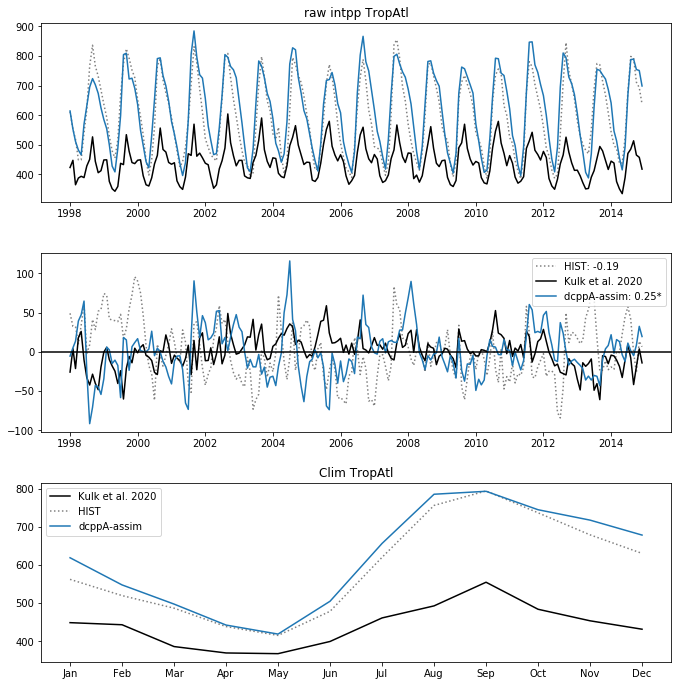

In [11]:
nline=3
ncol=1

fig, ax = plt.subplots(ncols=ncol, nrows=nline, 
                        figsize=(10, 10))

plt.tight_layout(pad=3)

obssdatelst=[]
for year in np.arange(year1,year2+2):
    for mon in range(1, 13):
        obssdatelst.append(date(year=year, month=mon, day=1))

        
ax[0].plot(obssdatelst[:(year2-year1+2)*12], indexhist, color="grey", linestyle="dotted")
ax[0].plot(obssdatelst, obs, color="black")
ax[0].plot(obssdatelst[:(year2-year1+2)*12], indexndg, color="C0")

       
        
ax[0].set_title("raw "+varname+ " "+regname)
    

#ax[0].legend(["ESA", "FOR", "dcppA-assim_r4i1p1f2", "dccpA-hindcast_May"])

ax[1].plot(obssdatelst[:(year2-year1+2)*12], anomhist, color="grey", linestyle="dotted")
ax[1].plot(obssdatelst, anomobs, color="black")
ax[1].plot(obssdatelst[:(year2-year1+2)*12], anomndg, color="C0")
ax[1].axhline(y=0, color="black")        

ax[1].legend(["HIST: "+corrstr(corrhist), obsname,  "dcppA-assim: "+corrstr(corrndg)])


nmon=12
for isdates in range(len(sdatelst)):
    modsdatelst=[]
    for imon in range(nmon):
        modsdatelst.append(sdatelst[isdates]+relativedelta(months=+imon))
        

ax[2].plot([s.strftime("%b") for s in modsdatelst], climobs, color="black")
ax[2].plot([s.strftime("%b") for s in modsdatelst], climhist, color="grey", linestyle="dotted")
ax[2].plot([s.strftime("%b") for s in modsdatelst], climndg, color="C0")
#ax[2].plot([s.strftime("%b") for s in modsdatelst], clims7, color="darkgreen")
#ax[2].plot([s.strftime("%b") for s in modsdatelst], climmod, color="darkgrey")

ax[2].set_title("Clim "+regname)

ax[2].legend([obsname, "HIST", "dcppA-assim"])
        
       

In [12]:
figdir="/home/prodhommec/cnrm/pastel/USERS/prodhommec/NO_SAVE/plot/Skill/"
figname=figdir+("Corr"+"_"+"NDG-obs"+"_"+varname+"_monstart-%i_"%monstart+regname)
figname=(figname+".pdf")

print(figname)
fig.savefig(figname)

/home/prodhommec/cnrm/pastel/USERS/prodhommec/NO_SAVE/plot/Skill/Corr_NDG-obs_intpp_monstart-1_TropAtl.pdf
